In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from matplotlib.colors import LogNorm
from scripts.analysis import data

In [5]:
repos = data.get_fake_star_repos_all()
print(
    f"{len(repos)} repos,",
    f"{len(repos[repos.n_stars_low_activity > 0])} with low activity,",
    f"{len(repos[repos.n_stars_clustered > 0])} with clusters,",
    f"{len(repos[(repos.n_stars_low_activity > 0) & (repos.n_stars_clustered > 0)])} with both",
)
repos.head()

15765 repos, 4095 with low activity, 12141 with clusters, 471 with both


,repo_id,repo_name,n_stars,n_stars_latest,n_stars_low_activity,p_stars_low_activity,n_stars_clustered,p_stars_clustered,p_stars_fake
0,NaN,zyzxxz/Bandicam-Lifetime-Crack-Free-Download,87.0,0.0,0.0,0.0,87.0,1.0,1.0
1,NaN,zz8nstokeronterry/dasdasfacxzcass,97.0,0.0,97.0,1.0,0.0,0.0,1.0
2,NaN,zyzxxz/IObit-Uninstaller-Latest-Version-Crack,77.0,0.0,0.0,0.0,77.0,1.0,1.0
3,NaN,zyzxxz/Autodesk-Maya-Crack,91.0,0.0,0.0,0.0,91.0,1.0,1.0
4,NaN,zyzxxz/ARK-2024,88.0,0.0,0.0,0.0,88.0,1.0,1.0


In [10]:
stars = data.get_stars_by_month_all()
print(sum(stars.n_stars_low_activity) + sum(stars.n_stars_clustered))
stars.head()

3746538.0


,repo,month,n_stars,n_stars_low_activity,n_stars_clustered,n_stars_other
0,002sj/Crypto-Trading-Bots-for-FREE-Binance-ByB...,2024-02,672.0,0.0,672.0,0.0
1,00Gaurav-Chauhan00/4k-Video-Downloader-Crack,2024-04,495.0,0.0,495.0,0.0
2,00x1337/Adobe-Main,2024-04,240.0,0.0,240.0,0.0
3,01072006/der8gyXjjYMQ6KFVAg,2024-04,65.0,59.0,0.0,6.0
4,01kaim/t8gj,2024-03,88.0,0.0,81.0,7.0


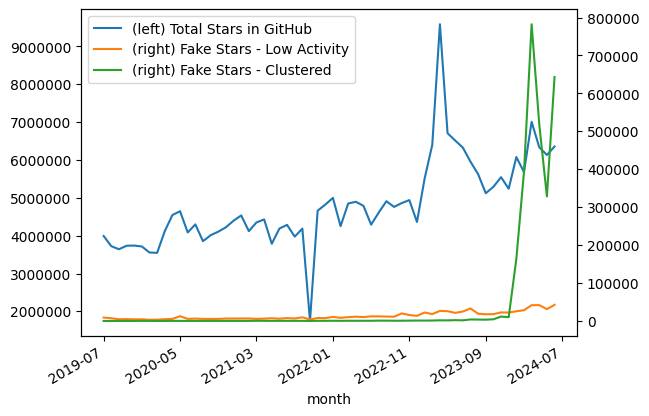

In [4]:
fig, ax = plt.subplots()
pd.read_csv("data/all_github_stars_by_month.csv").plot(
    ax=ax, secondary_y=False, logy=False
)
ax2 = (
    stars[stars.month != "2024-07"]
    .groupby("month")
    .agg(
        n_stars_low_activity=("n_stars_low_activity", "sum"),
        n_stars_clustered=("n_stars_clustered", "sum"),
    )
    .plot(ax=ax, secondary_y=True, logy=False)
)
# Ugly formatting code
ax2.ticklabel_format(style="plain", axis="y")
ax.ticklabel_format(style="plain", axis="y")
labels = ax.get_xticklabels()
labels[7].set_text("2024-07")
ax.set_xticklabels(labels)
ax.legend(
    labels=[
        "(left) Total Stars in GitHub",
        "(right) Fake Stars - Low Activity",
        "(right) Fake Stars - Clustered",
    ],
    handles=[ax.lines[0], ax2.lines[0], ax2.lines[1]],
)
fig.autofmt_xdate()

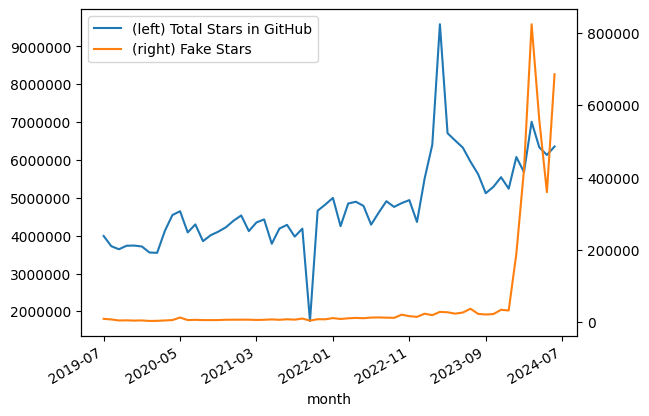

In [12]:
fig, ax = plt.subplots()
pd.read_csv("data/all_github_stars_by_month.csv").plot(
    ax=ax, secondary_y=False, logy=False
)
stars["n_stars_fake"] = stars.n_stars_low_activity + stars.n_stars_clustered
ax2 = (
    stars[stars.month != "2024-07"]
    .groupby("month")
    .agg(
        n_stars_fake=("n_stars_fake", "sum"),
    )
    .plot(ax=ax, secondary_y=True, logy=False)
)
# Ugly formatting code
ax2.ticklabel_format(style="plain", axis="y")
ax.ticklabel_format(style="plain", axis="y")
labels = ax.get_xticklabels()
labels[7].set_text("2024-07")
ax.set_xticklabels(labels)
ax.legend(
    labels=[
        "(left) Total Stars in GitHub",
        "(right) Fake Stars",
    ],
    handles=[ax.lines[0], ax2.lines[0]],
)
fig.autofmt_xdate()

In [8]:
repos_all = set(stars.repo)
repos_with_compaign = data.get_repo_with_compaign()
repos_alive = set(repos[repos.repo_id.notna()].repo_name)

print(f"{len(repos_with_compaign)} of {len(repos_all)} repos with campaign")
print(f"{len(repos_alive)} of {len(repos_all)} repos alive")
print(f"{len(repos_with_compaign & repos_alive)} repos with campaign and alive")

pypi_pkgs, pypi_downloads = data.get_pypi_pkgs_and_downloads()
print(
    f"{len(pypi_pkgs)} pkgs ({len(set(pypi_pkgs.github))} repos)"
    " with fake star campaign are in PyPI"
)
print(
    f"{len(set(pypi_pkgs.github) & repos_alive)}"
    " repos are in PyPI and have fake stars and are still alive"
)

npm_pkgs, npm_downloads = data.get_npm_pkgs_and_downloads()
print(
    f"{len(npm_pkgs)} pkgs ({len(set(npm_pkgs.github))} repos)"
    " with fake star campaign are in npm"
)
print(
    f"{len(set(npm_pkgs.github) & repos_alive)}"
    " repos are in npm and have fake stars and are still alive"
)

10155 of 15765 repos with campaign
5649 of 15765 repos alive
1136 repos with campaign and alive
47 pkgs (36 repos) with fake star campaign are in PyPI
34 repos are in PyPI and have fake stars and are still alive
41 pkgs (21 repos) with fake star campaign are in npm
20 repos are in npm and have fake stars and are still alive


Counter({False: 174688, True: 38736})
Counter({False: 62554, True: 13373})
Counter({False: 113917, True: 25762})


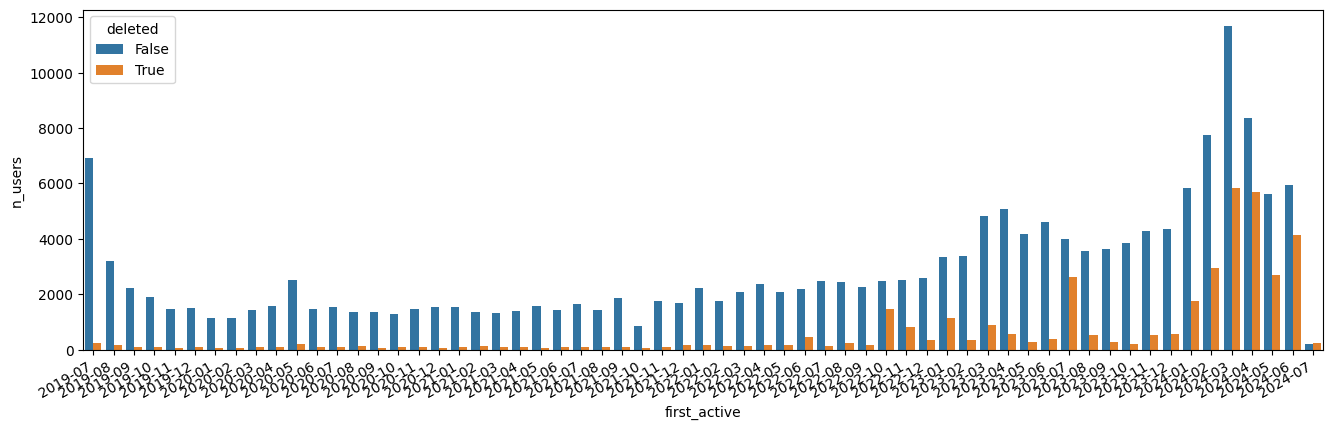

In [6]:
users = data.get_fake_star_users()

users.first_active = users.first_active.map(lambda x: x[:7])
users.last_active = users.last_active.map(lambda x: x[:7])

print(Counter(users.deleted))
print(Counter(users[users.clustered].deleted))
print(Counter(users[users.low_activity].deleted))

user_to_period = (
    users.groupby(["first_active", "last_active"])
    .size()
    .reset_index(name="n_users")
    .pivot(index="first_active", columns="last_active", values="n_users")
)
user_to_deletion = (
    users.groupby(["first_active", "deleted"]).size().reset_index(name="n_users")
)
# sns.heatmap(user_to_period, norm=LogNorm())
fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data=user_to_deletion, x="first_active", y="n_users", hue="deleted", ax=ax)
fig.autofmt_xdate()

Text(0.5, 0, '# of Active Months')

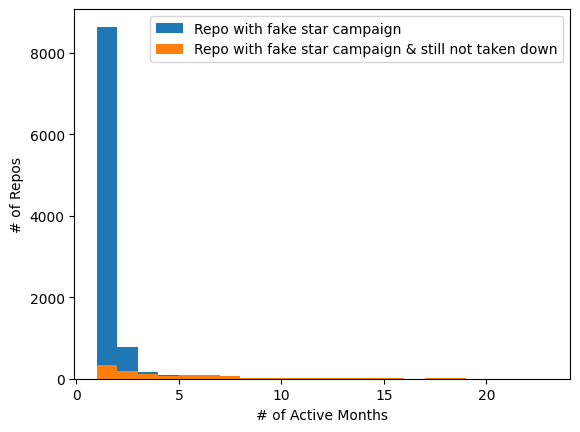

In [7]:
repo_to_months = (
    stars.groupby("repo")
    .agg(
        n_months=("month", "count"),
    )
    .reset_index()
)

fig, ax = plt.subplots()
repo_to_months[repo_to_months.repo.isin(repos_with_compaign)].plot(
    kind="hist",
    bins=range(1, 24),
    ax=ax,
)
repo_to_months[repo_to_months.repo.isin(repos_with_compaign & repos_alive)].plot(
    kind="hist",
    bins=range(1, 24),
    ax=ax,
)
ax.legend(
    [
        "Repo with fake star campaign",
        "Repo with fake star campaign & still not taken down",
    ]
)
ax.set_ylabel("# of Repos")
ax.set_xlabel("# of Active Months")

<Axes: xlabel='end', ylabel='start'>

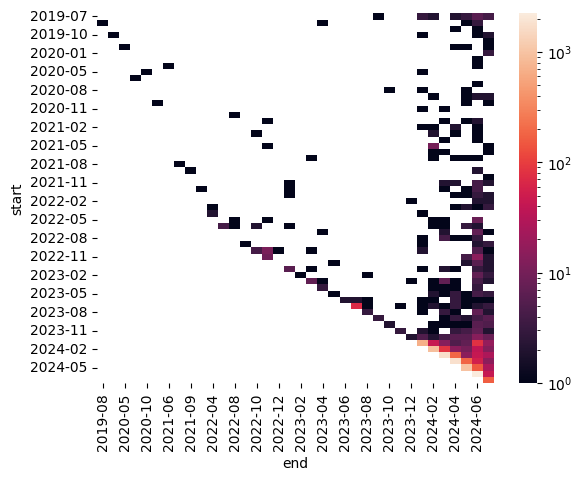

In [8]:
repo_to_period = (
    (
        stars[stars.repo.isin(repos_with_compaign)]
        .groupby("repo")
        .agg(
            start=("month", "min"),
            end=("month", "max"),
        )
        .reset_index()
    )
    .groupby(["start", "end"])
    .size()
    .reset_index(name="n_repos")
    .pivot(index="start", columns="end", values="n_repos")
)
sns.heatmap(repo_to_period, norm=LogNorm())

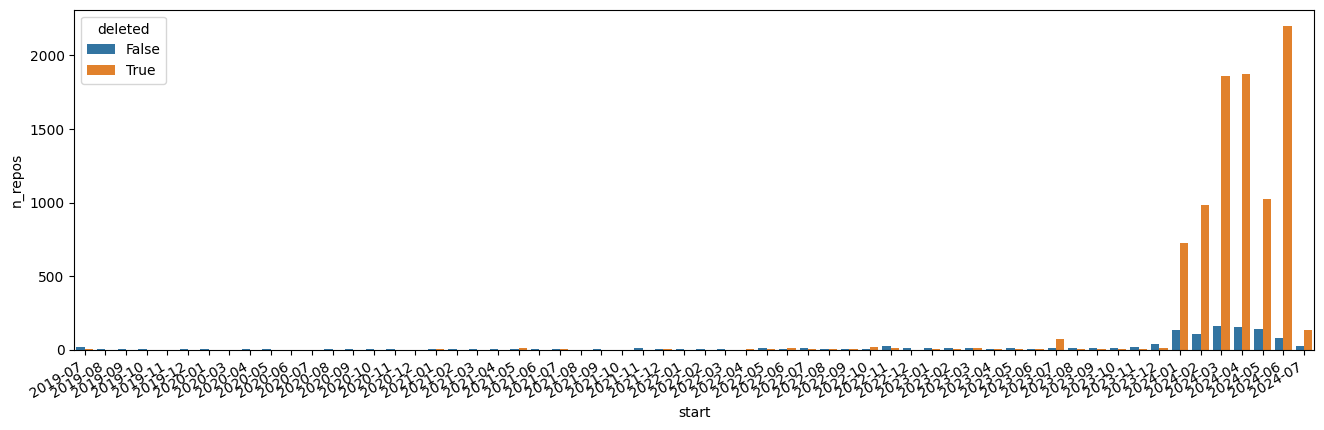

In [9]:
repo_to_deletion = (
    (
        stars[stars.repo.isin(repos_with_compaign)]
        .groupby("repo")
        .agg(
            start=("month", "min"),
        )
        .reset_index()
    )
    .join(repos.set_index("repo_name").repo_id.isna().rename("deleted"), on="repo")
    .groupby(["start", "deleted"])
    .size()
    .reset_index(name="n_repos")
)

fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data=repo_to_deletion, x="start", y="n_repos", hue="deleted", ax=ax)
fig.autofmt_xdate()

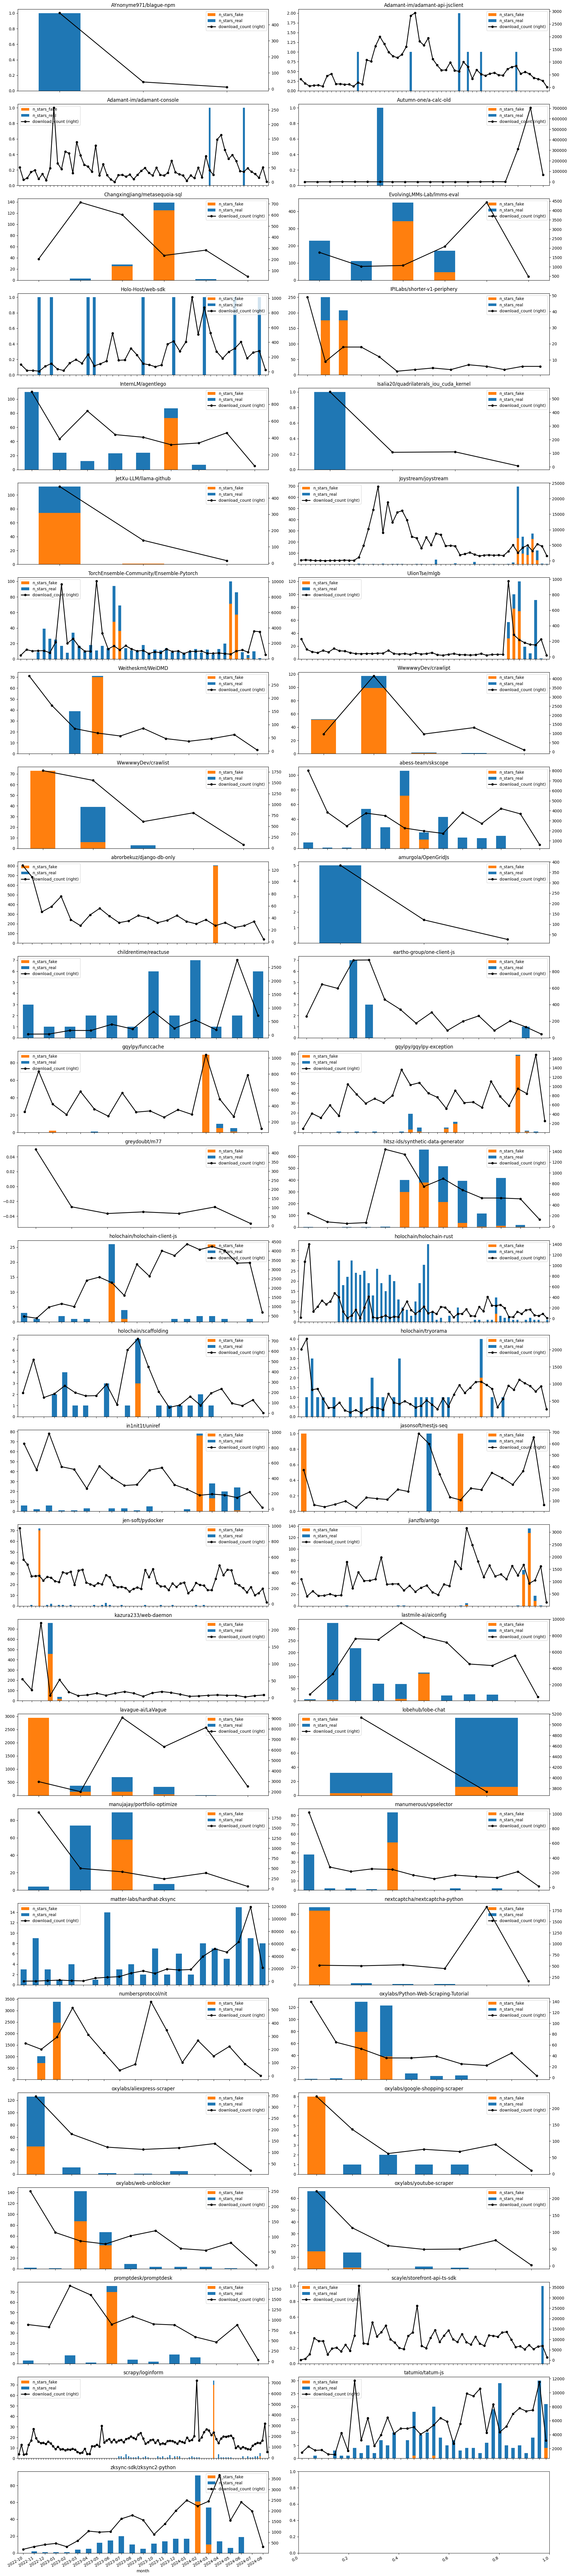

In [11]:
_, downloads = data.get_modeling_data()
fig, axes = plt.subplots(27, 2, figsize=(20, 90))
for i, (repo, df) in enumerate(downloads.groupby("repo")):
    df[["month", "n_stars_fake", "n_stars_real"]].plot(
        kind="bar",
        x="month",
        stacked=True,
        ax=axes[i // 2, i % 2],
        title=repo,
        color=["C1", "C0"],
    )
    df[["month", "download_count"]].plot(
        kind="line",
        x="month",
        ax=axes[i // 2, i % 2],
        secondary_y=True,
        color="black",
        style=".-",
        linewidth=2,
        markersize=10,
    )
fig.autofmt_xdate()
fig.tight_layout()

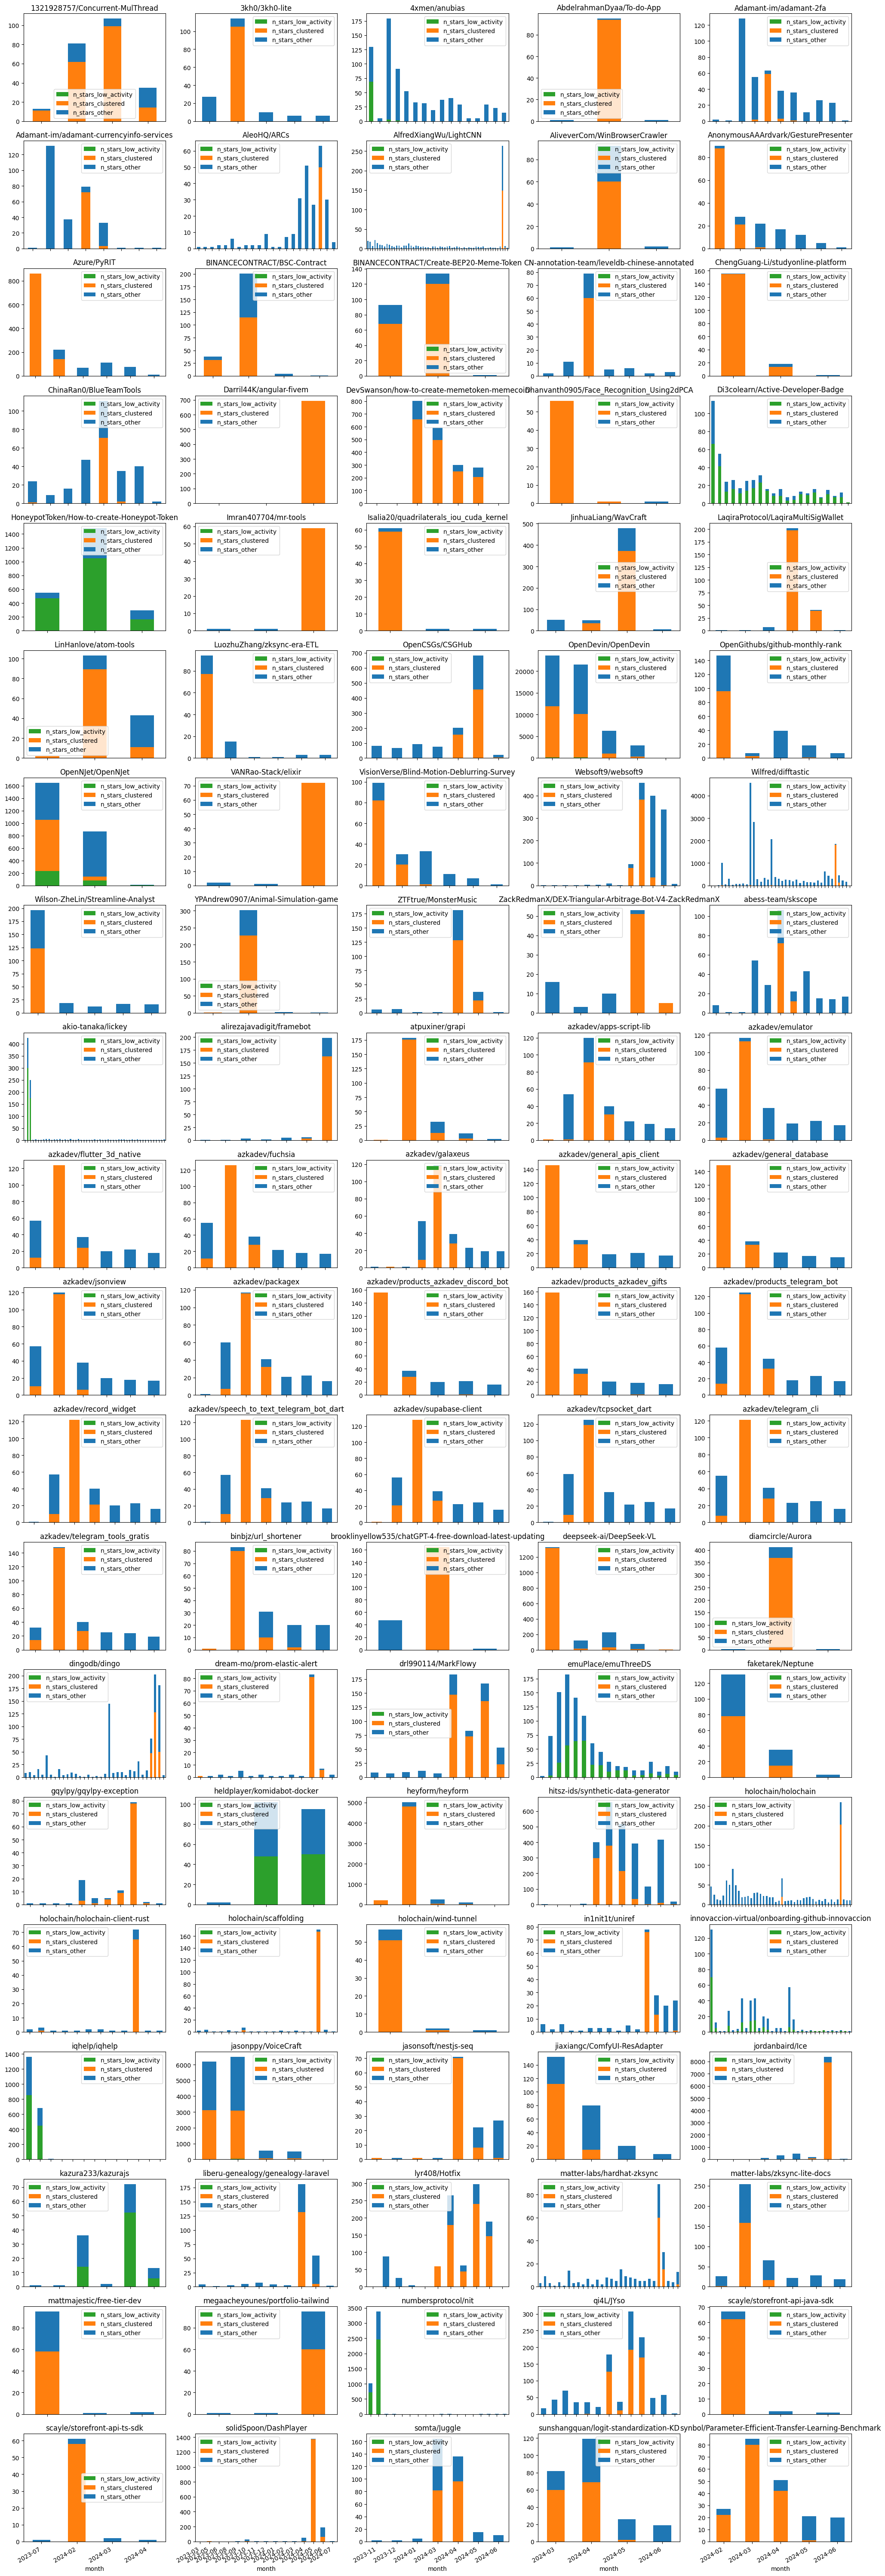

In [12]:
repo_samples = random.sample(
    sorted(
        (repos_alive & repos_with_compaign)
        & set(repo_to_months[repo_to_months.n_months >= 3].repo)
    ),
    100,
)
# repo_samples = list(successful_repos.head(100).repo_name)

fig, axes = plt.subplots(20, 5, figsize=(20, 60))
for i, (repo, df) in enumerate(stars[stars.repo.isin(repo_samples)].groupby("repo")):
    df[["month", "n_stars_low_activity", "n_stars_clustered", "n_stars_other"]].plot(
        kind="bar",
        x="month",
        stacked=True,
        ax=axes[i // 5, i % 5],
        title=repo,
        color=["C2", "C1", "C0"],
    )
fig.autofmt_xdate()
fig.tight_layout()